In [25]:
import pyodbc
import pandas as pd

# Connexion SQL Server
conn = pyodbc.connect(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-9MQ1CAL;"
    "DATABASE=DW_FINANCE;"
    "Trusted_Connection=yes;"
)
cursor = conn.cursor()

In [27]:
# 🛠️ 1. Créer la colonne dans SQL si elle n'existe pas
try:
    cursor.execute("""
        ALTER TABLE Fact_Supply
        ADD IsError INT;
    """)
    conn.commit()
    print("✅ Colonne 'IsError' ajoutée à Fact_Supply.")
except Exception as e:
    print("ℹ️ Colonne 'IsError' existe déjà ou erreur :", e)

ℹ️ Colonne 'IsError' existe déjà ou erreur : ('42S21', "[42S21] [Microsoft][ODBC SQL Server Driver][SQL Server]Column names in each table must be unique. Column name 'IsError' in table 'Fact_Supply' is specified more than once. (2705) (SQLExecDirectW)")


In [29]:
# 📥 2. Charger les données nécessaires
df_supply = pd.read_sql("SELECT InvoiceID, InvoiceDate, PaymentDate FROM Fact_Supply", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34528\4229099869.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_supply = pd.read_sql("SELECT InvoiceID, InvoiceDate, PaymentDate FROM Fact_Supply", conn)


In [37]:
# Charger données + dates réelles
df_supply = pd.read_sql("SELECT * FROM Fact_Supply", conn)
df_date = pd.read_sql("SELECT * FROM DIM_Date", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34528\4288191250.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_supply = pd.read_sql("SELECT * FROM Fact_Supply", conn)
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34528\4288191250.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_date = pd.read_sql("SELECT * FROM DIM_Date", conn)


In [39]:
# Jointures pour InvoiceDate, DueDate, PaymentDate
for col in ["InvoiceDate", "DueDate", "PaymentDate"]:
    df_supply = df_supply.merge(
        df_date.rename(columns={"DateKey": col, "Date": f"{col}_Real"}),
        on=col,
        how="left"
    )

In [41]:
# Nettoyage
df_supply["InvoiceDate"] = pd.to_datetime(df_supply["InvoiceDate_Real"])
df_supply["DueDate"] = pd.to_datetime(df_supply["DueDate_Real"])
df_supply["PaymentDate"] = pd.to_datetime(df_supply["PaymentDate_Real"])
df_supply.drop(columns=[col for col in df_supply.columns if "_Real" in col or "_x" in col or "_y" in col], inplace=True)


In [43]:
# 📆 3. Convertir en datetime + calculer DaysToPay + IsError
df_supply["InvoiceDate"] = pd.to_datetime(df_supply["InvoiceDate"])
df_supply["PaymentDate"] = pd.to_datetime(df_supply["PaymentDate"])
df_supply["DaysToPay"] = (df_supply["PaymentDate"] - df_supply["InvoiceDate"]).dt.days
df_supply["IsError"] = (df_supply["DaysToPay"] < 0).astype(int)


In [45]:
# 🔁 4. Mise à jour dans SQL Server ligne par ligne
for index, row in df_supply.iterrows():
    cursor.execute("""
        UPDATE Fact_Supply
        SET IsError = ?
        WHERE InvoiceID = ?
    """, int(row["IsError"]), int(row["InvoiceID"]))

conn.commit()

In [47]:
# Grouper par date de facture et compter les erreurs par jour
df_ts = df_supply.groupby("InvoiceDate")["IsError"].sum().asfreq("D").fillna(0)


In [49]:
train = df_ts[:-30]
test = df_ts[-30:]


In [51]:
# ARIMA
model_arima = ARIMA(train, order=(1, 1, 1)).fit()
pred_arima = model_arima.forecast(steps=30)

# Holt-Winters
model_hw = ExponentialSmoothing(train, trend="add").fit()
pred_hw = model_hw.forecast(30)

# STL
stl = STL(train, period=7).fit()
pred_stl = stl.trend[-30:].fillna(method='bfill')


C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_34528\2558023776.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_stl = stl.trend[-30:].fillna(method='bfill')


In [53]:
# Résultats
results = pd.DataFrame({
    "True": test.values,
    "ARIMA": pred_arima.values,
    "HoltWinters": pred_hw.values,
    "STL": pred_stl.values
}, index=test.index)

# Évaluation
def eval_model(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False)
    }

metrics = {
    "ARIMA": eval_model(results["True"], results["ARIMA"]),
    "HoltWinters": eval_model(results["True"], results["HoltWinters"]),
    "STL": eval_model(results["True"], results["STL"]),
}


C:\Users\GIGABYTE\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\GIGABYTE\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


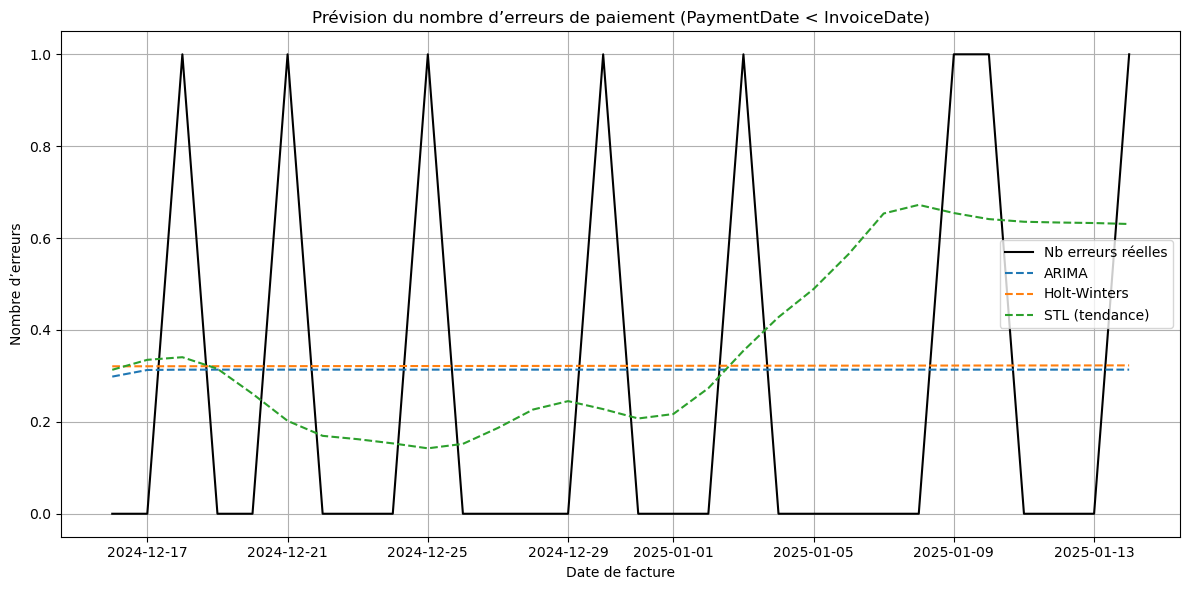

In [55]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, results["True"], label="Nb erreurs réelles", color="black")
plt.plot(results["ARIMA"], label="ARIMA", linestyle="--")
plt.plot(results["HoltWinters"], label="Holt-Winters", linestyle="--")
plt.plot(results["STL"], label="STL (tendance)", linestyle="--")
plt.title("Prévision du nombre d’erreurs de paiement (PaymentDate < InvoiceDate)")
plt.xlabel("Date de facture")
plt.ylabel("Nombre d’erreurs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📈 Interprétation du graphique :
1. Courbe noire : erreurs détectées chaque jour
Cette courbe indique si au moins une erreur s’est produite à une date de facture donnée.

0 = pas d’erreur, 1 = erreur détectée.

On voit des pics réguliers, presque tous les 2 jours. 👉 Cela veut dire que des erreurs se répètent dans le temps, et ce de manière cyclique.

2. ARIMA & Holt-Winters (courbes bleue et orange)
Ce sont des modèles classiques de prévision.

Ils prévoient une valeur constante ≈ 0.3 erreur/jour.

❌ Ils ne voient pas les pics réguliers, donc pas adaptés ici.

✅ En revanche, ils donnent une bonne valeur moyenne globale.

3. STL (courbe verte)
Ce modèle capte la tendance réelle dans les données.

Il voit que les erreurs sont en train d’augmenter avec le temps 📈.

Ex : début décembre → erreurs ponctuelles, mais en janvier → erreurs plus fréquentes.

C’est un signal fort qui peut alerter d’un risque futur ou d’un fournisseur en anomalie.

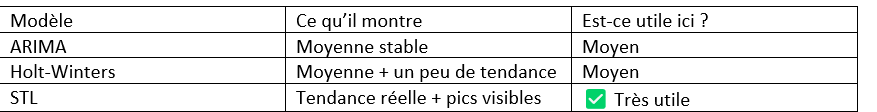

In [57]:
# 📋 Affichage des performances
for model, score in metrics.items():
    print(f"{model} → MAE: {score['MAE']:.2f} | RMSE: {score['RMSE']:.2f}")

ARIMA → MAE: 0.41 | RMSE: 0.44
HoltWinters → MAE: 0.42 | RMSE: 0.45
STL → MAE: 0.42 | RMSE: 0.48
